## Practical 3. Knowledge Graph Building with Spacy
### Strictly used for internal purpose in Singapore Polytechnic. Do not disclose!

In [47]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
from spacy.matcher import Matcher 
from spacy.tokens import Span 
import matplotlib.pyplot as plt
import networkx as nx
nlp = spacy.load('en_core_web_sm')
pd.set_option('display.max_colwidth', 200)

## 1. Read Data

In [3]:
wiki = pd.read_csv('data/wiki_sentences.csv')
wiki

sentence
0                                                 confused and frustrated, connie decides to leave on her own.
1                                                            later, a woman’s scream is heard in the distance.
2                                                                     christian is then paralyzed by an elder.
3                                                                                   the temple is set on fire.
4                                                                            outside, the cult wails with him.
...                                                                                                        ...
4313     confidencial also responded negatively, calling the film a barren drama, unsubtle and self-indulgent.
4314                                             and le parisien gave the film their highest five-star rating.
4315  the museum collection includes 37,000 film titles, 60,000 posters, 700,000 photographs and 20,000 books.
4316                                   its predecessor was the dutch historical film archive, founded in 1946.
4317                                                         , 1920'sfilmstar greta garbo by alexander binder,

[4318 rows x 1 columns]

In [52]:
doc = nlp('christian is then paralyzed by an elder')

for token in doc:
    print(token.text, '...', token.dep_)

christian ... nsubjpass
is ... auxpass
then ... advmod
paralyzed ... ROOT
by ... agent
an ... det
elder ... pobj


## 2. Entity Extraction
To build a knowledge graph, the most important things are the nodes and the edges between them

In [5]:
def get_entities(sent):
  ## chunk 1: store entities and dependencies
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""
  ############################################################# 
  for tok in nlp(sent):
    ## chunk 2: loop through sentence, and combine modifier compound word with entities
    if tok.dep_ != "punct":
      if tok.dep_ == "compound":
        prefix = tok.text
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3: subject spotted!
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4: object spotted
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5: update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [6]:
# test the function
get_entities('Joe Biden has won the US president election')

['Joe Biden', 'US president election']

In [7]:
# Extract entity pairs in each sentence
entity_pairs = []

for i in wiki["sentence"]:
  entity_pairs.append(get_entities(i))

In [12]:
entity_pairs[50:60]

[['film', 'originally  june'],
 ['collectible  tickets', 'two  sizes'],
 ['4k release', 'hdr10'],
 ['retail  exclusives', 'clear  files'],
 ['such  heroes', 'one  liners'],
 ['it', 'science fiction twist'],
 ['currently action films', 'extensive stunt work'],
 ['examples', 'indiana jones franchise'],
 ['themes', 'typical action horror films'],
 ['mall cop', 'recent  trend']]

## 3. Relation Extraction
The hypothesis is that the predicate is actually the main verb in a sentence. The function below is capable of capturing such predicates from the sentences.

In [34]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [36]:
# test the function
get_relation("Joe Biden has won the US presidential election")

'won'

In [37]:
relations = [get_relation(i) for i in wiki['sentence']]

In [41]:
# check the most frequent relations/predicate
pd.Series(relations).value_counts()[:30]

is               348
was              283
released on       82
are               73
were              67
include           61
                  50
's                41
released          39
have              31
became            29
has               29
released in       26
composed by       26
become            26
included          22
called            21
produced          21
been              20
considered        19
had               18
used              18
made              16
be                16
received          15
went              14
hired             14
scheduled         14
introduced in     13
wrote             13
dtype: int64

It turns out that relations like “A is B” and “A was B” are the most common relations. 

## 4. Build a Knowledge Graph
We will finally create a knowledge graph from the extracted entities (subject-object pairs) and the predicates (relation between entities).

In [42]:
# extract subject
subject = [i[0] for i in entity_pairs]

# extract object
object = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'subject':subject, 'object':object, 'edge':relations})

In [45]:
kg_df.head(5)

subject       object          edge
0         connie          own       decides
1  later  scream     distance      heard in
2      christian  then  elder  paralyzed by
3         temple         fire        set on
4  outside  cult          him    wails with

We will use networkx to create a network from this knowledge graph dataframe. The nodes will represent the entities and the edges or connections between the nodes will represent the relations between the nodes. It is going to be a **directed graph**. In other words, the relation between any connected node pair is not two-way, it is only from one node to another.

In [49]:
# create a directed-graph from a dataframe
G = nx.from_pandas_edgelist(kg_df, "subject", "object", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

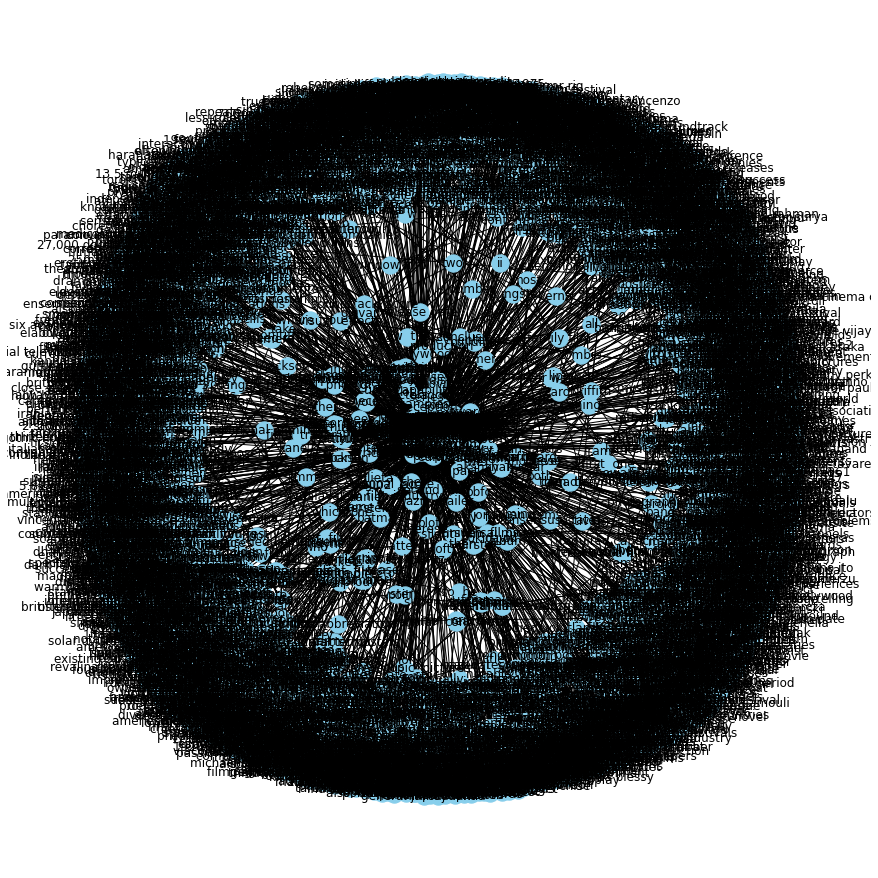

In [53]:
# plot the network
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

we have created a graph with all the relations that we had. It becomes really hard to visualize a graph with these many relations or predicates. Therefore, we should visualize one relationship at each time.

Let's try to visualize these relationships: [released, composed by, written by], one by one

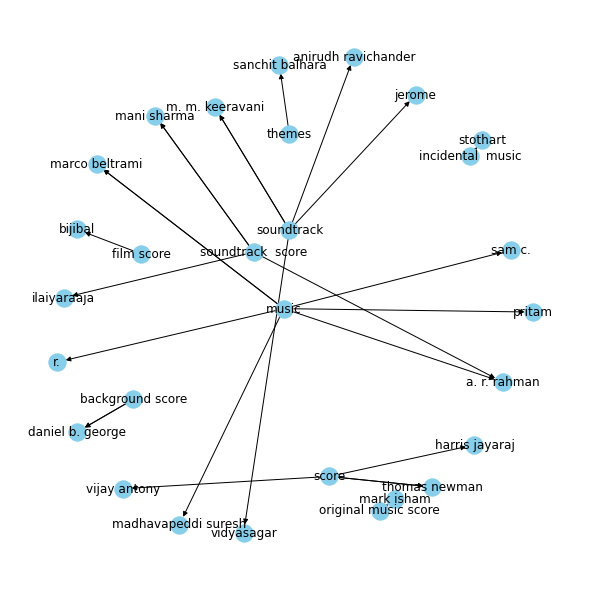

In [59]:
# let's take one relationship at a time
G = nx.from_pandas_edgelist(kg_df[kg_df['edge']=='composed by'], "subject", "object", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(8,8))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

For instance, A.R. Rahman, who is a renowned music composer, has entities like “soundtrack score”, “film score”, and “music” connected to him in the graph above.

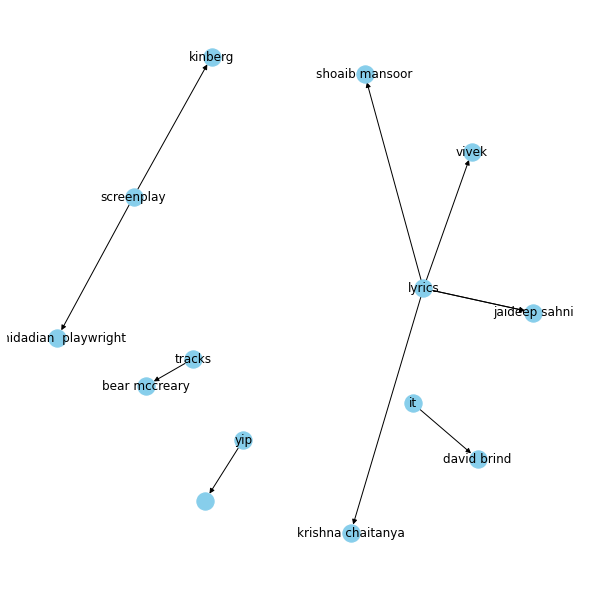

In [60]:
# let's take one relationship at a time
G = nx.from_pandas_edgelist(kg_df[kg_df['edge']=='written by'], "subject", "object", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(8,8))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

People like Krishna Chaitanya, and Jaideep Sahni are all famous lyricists and this graph beautifully captures this relationship

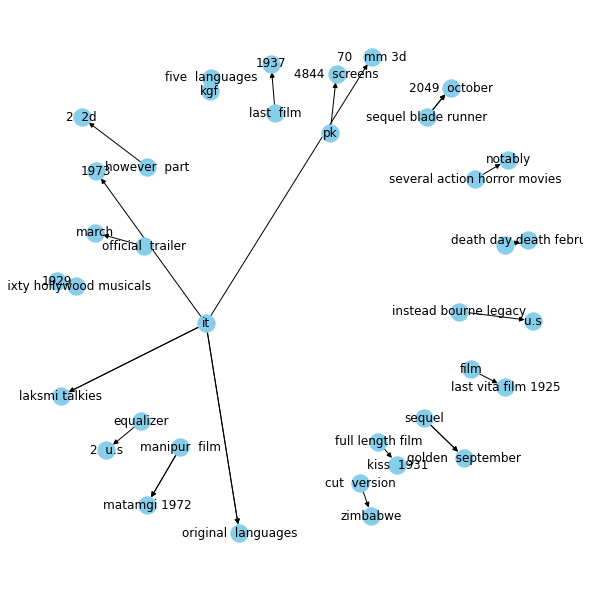

In [63]:
# let's take one relationship at a time
G = nx.from_pandas_edgelist(kg_df[kg_df['edge']=='released in'], "subject", "object", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(8,8))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

 For example, look at this relationship – **"several action horror movies released in the 1980s"** and **"pk released on 4844 screens"**. These are facts and it shows us that we can mine such facts from just text.